In [47]:
import numpy as np
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize']=(30,30)
plt.rcParams['image.cmap']='gray'
% %matplotlib inline

## 1.  prepare Data 

In [48]:
mnist_data_path='../AI_database/mnist/MNIST_DATA'
def imshow(X,Y=None,classes=None):
    '''
        show Batch of image in grids sqrt(h) x sqrt(w)
        X is a numpy array,size (m,h,w,c)
        Y is a numpy array,size (m,#classes)
    '''
    m=X.shape[0]
    gridSize=int(m**0.5)
    for i in range(0,gridSize):
        for j in range(0,gridSize):
            _idx=i*gridSize+j
            im=X[_idx]
            plt.subplot(gridSize,gridSize,_idx+1)
            plt.axis('off')
            plt.imshow(im)
            if Y is not None:
                label=classes[np.argmax(Y[_idx])]
                plt.title(label)

def load_dataset(flaten=False,one_hot=True):
    def _make_one_hot(d,C=10):
        return (np.arange(C)==d[:,None]).astype(np.int32)

    mnist=input_data.read_data_sets(mnist_data_path)
    X_train,Y_train=mnist.train.images,mnist.train.labels
    X_test,Y_test=mnist.test.images,mnist.test.labels

    if flaten==False:
        X_train=X_train.reshape((-1,28,28,1))
        X_test = X_test.reshape((-1, 28, 28,1))
    if one_hot:
        Y_train = _make_one_hot(Y_train)
        Y_test=_make_one_hot(Y_test)


    print('\n-------------------------------------------------------------------------')
    print('load %d train Example,%d Test Example'%(X_train.shape[0],X_test.shape[0]))
    print('Train Images  Shape:'+str(X_train.shape))
    print('Train Labels  Shape:' + str(Y_train.shape))
    print('Test  Images  Shape:'+str(X_test.shape))
    print('Test  Labels  Shape:' + str(Y_test.shape))
    print('-------------------------------------------------------------------------')
    return (X_train,Y_train,X_test,Y_test)

In [49]:
X_train,Y_train,X_test,Y_test=load_dataset(flaten=True,one_hot=True)

Extracting ../AI_database/mnist/MNIST_DATA/train-images-idx3-ubyte.gz
Extracting ../AI_database/mnist/MNIST_DATA/train-labels-idx1-ubyte.gz
Extracting ../AI_database/mnist/MNIST_DATA/t10k-images-idx3-ubyte.gz
Extracting ../AI_database/mnist/MNIST_DATA/t10k-labels-idx1-ubyte.gz

-------------------------------------------------------------------------
load 55000 train Example,10000 Test Example
Train Images  Shape:(55000, 784)
Train Labels  Shape:(55000, 10)
Test  Images  Shape:(10000, 784)
Test  Labels  Shape:(10000, 10)
-------------------------------------------------------------------------


In [50]:
#for simply I defina a generator
def getNext(X,batch=128,noise=1):
    X=X.copy()
    m=X.shape[0]
    if (m%batch)>0:X=X[:-(m%batch)] #drop out the remain data
        
    m=X.shape[0]  
    real_batch=batch//2
    np.random.shuffle(X)
    
    i=0
    while True:
        xs=np.random.rand(batch,784).astype(np.float32)
        ys=np.zeros((batch,1),dtype=np.bool)
        start=(i*real_batch )%m
        end=start+real_batch
        
        xs[0:real_batch]=X[start:end]
        xs[real_batch:]=X[start:end]+noise*np.random.rand(real_batch,28*28)
        
        xs=xs/np.max(xs,axis=1,keepdims=True)
        ys[0:real_batch]=True
        yield (xs,ys)
        i+=1

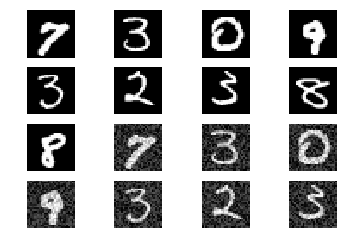

In [51]:
gen=getNext(X_train,18,0.5)
imshow(next(gen)[0].reshape(-1,28,28))

## 1.Defina a Discriminator model,2 layer neural Network

In [52]:
class Discriminator():
    def __init__(self,n_x,n_h,seed=None,logdir=None):
        self.scope='discriminatior'
        self.n_x=n_x
        self.n_h=n_h
        self.seed=seed
        self.logdir=logdir
    def __input__(self):
        X=tf.placeholder(shape=[None,self.n_x],dtype=tf.float32)
        Y=tf.placeholder(shape=[None,1],dtype=tf.bool)
        return X,Y
    def model(self,X):
        '''
            X:is a Image,shape (?,n_x)
        '''
        with tf.variable_scope(self.scope,reuse=tf.AUTO_REUSE):
            X=tf.contrib.layers.fully_connected(X,self.n_h,activation_fn=tf.nn.relu,
                weights_initializer=tf.contrib.layers.xavier_initializer(uniform=False,seed=self.seed)) 
            #should have shape [?,n_x]
            X=tf.contrib.layers.fully_connected(X,1,activation_fn=None,
                weights_initializer=tf.contrib.layers.xavier_initializer(uniform=False,seed=self.seed)) 
            #should have shape [?,1]
        return X
    def loss(self,label,logit):
        with tf.variable_scope(self.scope,reuse=tf.AUTO_REUSE):
    #         prob=tf.sigmoid(logit)
    #         label=tf.cast(label,tf.float32)
    #         l=label*tf.log(prob)+(1-label)*tf.log(1-prob)
    #         l=-tf.reduce_mean(l)
            l=tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=logit,labels=tf.cast(label,tf.float32)))
        return l
    def get_initializer(self):
        varlist=[v for v in tf.get_collection(tf.GraphKeys.VARIABLES) if v.name.startswith(self.scope)]
        return varlist
    
    def fit(self,sess,gen,steps,validset=None,lr=1e-4,epoch=10,print_every=100):
        '''
            first build model
        '''
        X,Y=self.__input__()
        Yhat=self.model(X)
        cost=self.loss(label=Y,logit=Yhat)
        
        varslist=tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES,scope=self.scope)
        
        with tf.variable_scope(self.scope,reuse=tf.AUTO_REUSE):
            optimizer=tf.train.AdamOptimizer(lr).minimize(cost,var_list=varslist)
        
        predict=Yhat>=0
        accuracy=tf.reduce_mean(tf.cast(tf.equal(Y,predict),tf.float32))

        ####################################################################
        history_loss,history_acc=[],[]
        if(self.logdir):
            tf.summary.FileWriter(self.logdir,sess.graph)
        sess.run(tf.variables_initializer(self.get_initializer()))
        for e in range(epoch):
            for s in range(steps):
                xs,ys=next(gen)
                _,_loss=sess.run([optimizer,cost],feed_dict={X:xs,Y:ys})
                
                if (s==0 or s%print_every==0):
                    if s==0:
                        if validset:Xdata,Ydata=validset
                        else:Xdata,Ydata=xs,ys
                        acc=sess.run(accuracy,feed_dict={X:Xdata,Y:Ydata})
                        print('epoch %d,acc: %f'%(e,acc))  
                    history_loss.append(_loss)
                    history_acc.append(acc)
                    print('--------------->',np.round(_loss,4))
        return history_loss,history_acc
    def predict(self,sess,x):
        X,Y=self.__input__()
        Yhat=self.model(X)
        prob=tf.nn.sigmoid(Yhat)
        predict=prob>=0.5
        _prob,_predict=sess.run([prob,predict],feed_dict={X:x})
        return _prob,_predict

## 2.Train the Discriministor

In [53]:
batch,epoch=128,10
gen=getNext(X_train,batch,noise=1)
m=2*X_train.shape[0]


tf.reset_default_graph()
net1=Discriminator(n_x=784,n_h=128,logdir=None)
sess=tf.Session()
his_loss,his_acc=net1.fit(sess,gen,steps=2*m//batch,epoch=epoch,print_every=500)

# plt.subplot(1,2,1)
# plt.plot(history_loss)
# plt.title('loss')

# plt.subplot(1,2,2)
# plt.plot(his_acc)
# plt.title('acc')

epoch 0,acc: 0.492188
---------------> 0.7817
---------------> 0.0031
---------------> 0.0011
---------------> 0.0005
epoch 1,acc: 1.000000
---------------> 0.0006
---------------> 0.0005
---------------> 0.0002
---------------> 0.0001
epoch 2,acc: 1.000000
---------------> 0.0001
---------------> 0.0001
---------------> 0.0
---------------> 0.0
epoch 3,acc: 1.000000
---------------> 0.0
---------------> 0.0
---------------> 0.0
---------------> 0.0
epoch 4,acc: 1.000000
---------------> 0.0
---------------> 0.0
---------------> 0.0
---------------> 0.0
epoch 5,acc: 1.000000
---------------> 0.0
---------------> 0.0
---------------> 0.0
---------------> 0.0
epoch 6,acc: 1.000000
---------------> 0.0
---------------> 0.0
---------------> 0.0
---------------> 0.0
epoch 7,acc: 1.000000
---------------> 0.0
---------------> 0.0
---------------> 0.0
---------------> 0.0
epoch 8,acc: 1.000000
---------------> 0.0
---------------> 0.0
---------------> 0.0
---------------> 0.0
epoch 9,acc: 1.0

## 3.predict Data,See whether it's a good discriministor ???

(array([[ 1.        ],
       [ 1.        ],
       [ 1.        ],
       [ 1.        ],
       [ 1.        ],
       [ 1.        ],
       [ 1.        ],
       [ 1.        ],
       [ 1.        ],
       [ 0.5396741 ],
       [ 0.98936415],
       [ 0.0963315 ],
       [ 0.98868328],
       [ 0.02406153],
       [ 0.00535596],
       [ 0.63969696],
       [ 0.74416214],
       [ 0.95909256]], dtype=float32), array([[ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [False],
       [ True],
       [False],
       [False],
       [ True],
       [ True],
       [ True]], dtype=bool))


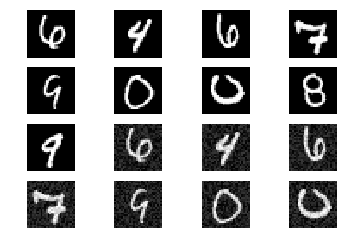

In [74]:
gen=getNext(X_test,18,noise=0.3)
xs,ys=next(gen)
imshow(xs.reshape((-1,28,28)))
print(net1.predict(sess,xs))

## 1 .Define A Generator Model

In [98]:
class Generator():
    def __init__(self,n_z,n_h=128,n_x=784,seed=None):
        self.scope='generator'
        self.n_x=n_x
        self.n_h=n_h
        self.n_z=n_z
        self.seed=seed
    def model(self,Z):
        with tf.variable_scope(self.scope,reuse=tf.AUTO_REUSE):
            X=tf.contrib.layers.fully_connected(Z,self.n_h,activation_fn=tf.nn.relu,
                weights_initializer=tf.contrib.layers.xavier_initializer(uniform=False,seed=self.seed))
            X=tf.contrib.layers.fully_connected(X,self.n_x,activation_fn=tf.nn.sigmoid,
                weights_initializer=tf.contrib.layers.xavier_initializer(uniform=False,seed=self.seed))
        return X
    def loss(self,logit):
        with tf.variable_scope(self.scope,reuse=tf.AUTO_REUSE):
            l=-tf.reduce_mean(tf.log(tf.nn.sigmoid(logit)))
        return l
    
    def fit(self,sess,disNet,batch=128,lr=1e-4,iters=1000,print_every=100,reInit=True):
        '''
            As usual,build Model
        '''
#         Z=tf.random_normal(shape=(batch,self.n_z),seed=self.seed)
        Z=tf.random_uniform((batch,self.n_z),0,2,seed=self.seed);
        X=self.model(Z)
        Yhat=disNet.model(X)
        cost=self.loss(Yhat)
        
        varlist=tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES,scope=self.scope)
        with tf.variable_scope(self.scope,reuse=tf.AUTO_REUSE):
            optimizer=tf.train.AdagradOptimizer(lr).minimize(cost,var_list=varlist)
        predict=Yhat>=0
        accuracy=tf.reduce_mean(tf.cast(predict,tf.float32))
        
        
        ####################################################################
        history_loss,history_acc=[],[]
        if(reInit):
            sess.run(tf.variables_initializer(self.get_initializer()))
        for i in range(iters):
            _,_cost=sess.run([optimizer,cost])
            if (i%print_every==0):
                acc=sess.run(accuracy)
                print('iters %d,acc: %f'%(i,acc))  
                history_loss.append(_cost)
                history_acc.append(acc)
                print('loss--------------->',np.round(_cost,4))
        return his_loss,his_acc
    def predict(self,sess,d=None,batch=128):
        if d is None:
            d=tf.random_normal(shape=(batch,self.n_z),seed=self.seed)
        X=self.model(d)
        x=sess.run(X)
        return x
    
    def get_initializer(self):
        varlist=[v for v in tf.get_collection(tf.GraphKeys.VARIABLES) if v.name.startswith(self.scope)]
        return varlist

## 2.Prepare Dataset and Train it

iters 0,acc: 0.773438
loss---------------> 3.7353
iters 100,acc: 0.750000
loss---------------> 3.1063
iters 200,acc: 0.710938
loss---------------> 4.741
iters 300,acc: 0.765625
loss---------------> 4.4669
iters 400,acc: 0.765625
loss---------------> 3.2232
iters 500,acc: 0.820312
loss---------------> 2.4506
iters 600,acc: 0.734375
loss---------------> 4.0206
iters 700,acc: 0.726562
loss---------------> 3.8946
iters 800,acc: 0.804688
loss---------------> 3.9459
iters 900,acc: 0.695312
loss---------------> 2.4857
iters 1000,acc: 0.773438
loss---------------> 4.0358
iters 1100,acc: 0.796875
loss---------------> 4.2369
iters 1200,acc: 0.734375
loss---------------> 4.3204
iters 1300,acc: 0.726562
loss---------------> 3.7536
iters 1400,acc: 0.718750
loss---------------> 2.4827
iters 1500,acc: 0.750000
loss---------------> 2.4508
iters 1600,acc: 0.750000
loss---------------> 3.2213
iters 1700,acc: 0.726562
loss---------------> 3.7614
iters 1800,acc: 0.750000
loss---------------> 3.9659
iters 

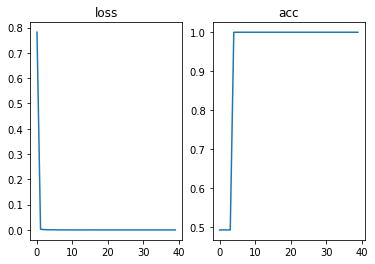

In [95]:
# net2=Generator(n_x=784,n_z=2,n_h=128)
his_loss,his_acc=net2.fit(sess,net1,batch=128,iters=100000,print_every=100,reInit=False)

plt.subplot(1,2,1)
plt.plot(his_loss)
plt.title('loss')

plt.subplot(1,2,2)
plt.plot(his_acc)
plt.title('acc')

## 3.Generate New Data

(array([[  9.99998331e-01],
        [  4.08809583e-11],
        [  1.00000000e+00],
        [  1.04124376e-09]], dtype=float32), array([[ True],
        [False],
        [ True],
        [False]], dtype=bool))

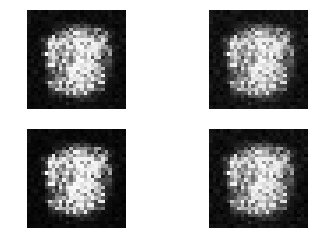

In [107]:
z=np.random.rand(4,2).astype(np.float32)
x=net2.predict(z)
imshow(x.reshape((-1,28,28)))
net1.predict(sess,x)

In [102]:
def generator(Z,seed=None):
    with tf.variable_scope('generator'):
        X=tf.contrib.layers.fully_connected(Z,128,activation_fn=tf.nn.relu,
            weights_initializer=tf.contrib.layers.xavier_initializer(uniform=False,seed=seed))
        X=tf.contrib.layers.fully_connected(X,784,activation_fn=tf.nn.sigmoid,
            weights_initializer=tf.contrib.layers.xavier_initializer(uniform=False,seed=seed))
    return X

In [ ]:
Z=tf.placeholder(shape=[None,2],dtype=tf.float32)
X=generator(Z)
Yhat=discriminatior(X)

## 2.Define Generator loss

In [ ]:
def generator_loss(logit):
    return -tf.reduce_mean(tf.log(tf.nn.sigmoid(logit)  ))

In [ ]:
gen_loss=generator_loss(Yhat)

## 3.Define predict,accuracy,optimizer

In [ ]:
predict=Yhat>=0
accuracy=tf.reduce_mean(tf.cast(predict,tf.float32))

generator_var=tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES,scope='generator')
generator_initializer=tf.variables_initializer(generator_var,name='generatot_init')
gen_optimizer=tf.train.AdamOptimizer(1e-4).minimize(gen_loss,var_list=generator_var)

In [ ]:
def trainZ(model,iters=1000,batch=128,print_every=100):
    
    X,opt,loss,accuracy=model
    history_loss,history_acc=[],[]

    for i in range(iters):
        xs=np.random.rand(batch,2)
        
        _,_loss=sess.run([opt,loss],feed_dict={X:xs})
        if (i==0 or i%print_every==0):
            acc=accuracy.eval(feed_dict={X:xs})
            print('iters %d,acc: %f'%(i,acc))  
            history_loss.append(_loss)
            history_acc.append(acc)
            print('loss--------------->',np.round(_loss,4))
    return history_loss,history_acc

## 4.Train Generator

In [ ]:
iters,batch=1000,128
generator_initializer.run()
##########################Initial beta1,beta2....###############################################
a=tf.get_collection(tf.GraphKeys.VARIABLES)
b=[x for x in a if x not in discriminative_var and x not in generator_var]
tf.variables_initializer(b).run()
#########################################################################
# sess.run([gen_optimizer],feed_dict={Z:np.random.randn(1,2)})
history_loss,history_acc=trainZ([Z,gen_optimizer,gen_loss,accuracy],iters,batch)

In [ ]:
plt.plot(history_loss)

In [ ]:
plt.plot(history_acc)

In [ ]:
a=tf.train.AdamOptimizer()

In [ ]:
dir(a)

In [ ]:
dir(gen_optimizer)